In [1]:
import os, sys

PATH_DATA = os.path.dirname(os.path.dirname(os.getcwd()))
PATH_DATA

'/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index'

In [2]:
import pandas as pd
import numpy as np
import shapefile as shp
import osmnx as ox
import contextily as ctx
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D  # for legend handle
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics.pairwise import haversine_distances
from shapely.geometry import Point
from pyproj import Proj, transform
import math
from matplotlib.colors import Normalize

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "../src"))
import functions_support as fsupport

import importlib

importlib.reload(fsupport)

<module 'functions_support' from '/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/notebooks/../src/functions_support.py'>

## Global variables


In [3]:
COUNTRY_NAME = "peru"
RESULT_DIR = "results_RETURN_FLOODS"

In [4]:
directory = PATH_DATA + "/data/" + COUNTRY_NAME + "/" + RESULT_DIR
if not os.path.exists(directory):
    os.makedirs(directory)

## Administrative areas


In [5]:
path = (
    PATH_DATA + "/data/" + COUNTRY_NAME + "/preprocessed_sources/administrative_region"
)
files = os.listdir(path)

administrative_areas_dict = dict()

for i in files:
    name = fsupport.capitalize_string(i[:-8])
    # adminitration = fsupport.capitalize_string(i[-9:-8])
    # # key_tag = f'{name} {fsupport.category_dict[adminitration]}'
    # key_tag = f'{name}{adminitration}'
    administrative_areas_dict[name] = gpd.read_file(path + "/" + i)

administrative_areas_dict.keys()

dict_keys(['Administration 2', 'Administration 3', 'Administration 1'])

## Shock

We will only work with the list of hazards that are enabled for our study.


In [7]:

shock_dict = {
    "1-5": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes_floods_return/shapes_1_mas/Flood_1in5/Flood_1in5.shp",
    "1-500": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes_floods_return/shapes_1_mas/Flood_1in500/Flood_1in500.shp",
    "1-1000": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes_floods_return/shapes_1_mas/Flood_1in1000/Flood_1in1000.shp",
}

## Risk Factors

Reading risk factor ratios


In [8]:
path = f"{PATH_DATA}/data/{COUNTRY_NAME}/preprocessed_sources/partial_rick_factors.csv"
# data/colombia/preprocessed_sources/partial_rick_factors.csv

country_vulnerability = pd.read_csv(
    path,
    dtype={
        "administration_1_code": str,
        "administration_2_code": str,
        "administration_3_code": str,
    },
)
country_vulnerability = fsupport.rename_columns(country_vulnerability)
country_vulnerability.head()

,Administration 3 Code,Per Indigenous Pop,Per Pobrezanbi,Per Inmu Neumoco,Per Inmu Influenza,Per Desnutricion,Per Analfabetismo,ValorConcentracióndeEESSdel,Per Serv Agua Public,Per Serv Electricidad Public,...,Per Masde40,ValorEESSconmayorcapacidadr,MEDICOX10000HABITANTENORMAL,Per Ess 100hab,PHC Dist Km,Hospital Dist Km,Rr Eda,Rr Resp,Rr Cv,Rr Dm
0,010101,0.04878,0.120,0.892,0.616,0.121,0.017160,0.18,0.375000,0.375000,...,0.000000,0.09,3.962652,4.995941,6667.752627,6671.790868,1.491073,2.528918,3.492367,1.716899
1,010102,0.29771,0.734,0.525,0.570,0.177,0.011111,0.40,1.000000,1.000000,...,1.000000,0.35,0.000000,68.965515,5651.642017,5655.783056,1.491073,2.672261,4.511592,2.551873
2,010103,0.00000,0.378,0.801,0.876,0.218,0.105856,0.30,0.666667,0.666667,...,0.333333,0.18,8.382230,84.745766,7485.610227,7488.471564,1.491073,2.496745,3.509281,1.819060
3,010104,0.00000,0.273,0.929,0.768,0.166,0.037037,0.40,1.000000,1.000000,...,0.000000,0.35,0.000000,22.271715,5652.882593,5656.891129,1.491073,2.625809,3.953724,2.089000
4,010105,0.00000,0.591,1.186,1.022,0.204,0.080906,0.30,0.750000,0.750000,...,0.000000,0.35,16.366612,212.765961,5947.002946,5951.123279,1.491073,2.639062,3.934412,2.072502


Let's perform a join operation between the most granular administrative region and hospitals. `country_vulnerability` and `administrative_areas`.
<br>
The idea is to assign each point or area to the most granular administrative region, and therefore to the higher-level ones.


## Analysis for each phenomenon


In [9]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

In [10]:
ADMINISTRATION_STUDY = "Administration 3 Code"

shock_list = ["1-5", "1-500", "1-1000"]

In [11]:
for shock in shock_list:
    data_vector = None
    print("     Processing for: " + shock)

    print("        Reading population")
    path = (
        f"{directory}/{shock}/{COUNTRY_NAME}_exposed_population_{shock}_adm3_table.csv"
    )
    country_shock_pop = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})
    country_shock_pop = country_shock_pop[[ADMINISTRATION_STUDY, "Percentage"]]

    print("        Reading Hospitals")
    path = f"{directory}/{shock}/{COUNTRY_NAME}_exposed_health_infrastructure_{shock}_adm3_table.csv"
    country_shock_hos = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})
    country_shock_hos = country_shock_hos[
        [
            ADMINISTRATION_STUDY,
            "Percentage Category I",
            "Percentage Category II",
            "Percentage Category III",
        ]
    ]

    data_vector = pd.merge(
        country_shock_pop,
        country_shock_hos,
        how="inner",  # right
        left_on=[
            ADMINISTRATION_STUDY,
        ],
        right_on=[
            ADMINISTRATION_STUDY,
        ],
        sort=True,
        suffixes=("_x", "_y"),
    )

    data_vector = data_vector[~(data_vector["Percentage"] == 0)].reset_index(drop=True)

    data_vector = pd.merge(
        data_vector,
        country_vulnerability,
        how="inner",  # right
        left_on=[
            ADMINISTRATION_STUDY,
        ],
        right_on=[
            ADMINISTRATION_STUDY,
        ],
        sort=True,
        suffixes=("_x", "_y"),
    )

    # data_vector.fillna(0, inplace=True)
    data_vector["Percentage"] = data_vector["Percentage"] / 100
    data_vector["Percentage Category I"] = data_vector["Percentage Category I"] / 100
    data_vector["Percentage Category II"] = data_vector["Percentage Category II"] / 100
    data_vector["Percentage Category III"] = (
        data_vector["Percentage Category III"] / 100
    )

    path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"
    print("        Saving:", path)
    data_vector.to_csv(path, index=False)

     Processing for: 1-5
        Reading population
        Reading Hospitals
        Saving: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-5/peru_1-5_variables_table.csv
     Processing for: 1-500
        Reading population
        Reading Hospitals
        Saving: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-500/peru_1-500_variables_table.csv
     Processing for: 1-1000
        Reading population
        Reading Hospitals
        Saving: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-1000/peru_1-1000_variables_table.csv


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import warnings

## Distances & Kmean


In [13]:
def distancia_euclidiana(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)


def distancia_euclidiana_df(df):
    ideal_values = df.iloc[:1, 1:].values[0]
    df["Risk To Measure"] = df.apply(
        lambda x: distancia_euclidiana(ideal_values, list(x[1:])), axis=1
    )
    return df


def cosine_similarity(A, B):
    cosine = np.dot(A, B) / (norm(A) * norm(B) + 0.00000000001)
    ### warning
    if cosine < 0:
        warnings.warn("Warning: values < 0")
        return 0
    return cosine


def similarity(x, y):
    cosine = np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y) + 0.00000000001)
    return np.where(cosine > 0, cosine, 0)
    # return cosine


def cosine_similarity_df(df):
    ideal_values = df.iloc[:1, 1:].values[0]
    df["Cosine Similarity"] = df.apply(
        lambda x: similarity(ideal_values, list(x[1:])), axis=1
    )

    # values = df.apply(lambda x: similarity(ideal_values, list(x[1:])), axis = 1)
    df["Cosine Distance"] = 1 - df["Cosine Similarity"]
    # df['cosine'] = np.where(np.isnan(df['cosine']), 0, df['cosine'])  # Reemplazar NaN con 0

    df["Risk To Measure"] = df["Cosine Distance"]
    return df

In [14]:
ideal_values = [
    0.05,  # 'Exposed population' --> ('Percentage')
    0.01,  # 'Percentage of exposed Primary healthcare' ('Percentage Category I')
    0.01,  #'Percentage of exposed hospital category II' ('Percentage Category II')
    0.01,  #'Percentage of exposed hospital category III' --> ('Percentage Category III')
    0.01,  # 'Porcentaje de Población indigena' # deberia ser 0 --> ('Per Indigenous Pop')
    0.05,  # 'Porcentaje de Población censada con al menos una NBI' --> ('Per Pobrezanbi')
    0.9,  # 'Cobertura de vacunacion contra neumococo en menores de 1 año' --> ('Per Inmu Neumoco')
    0.74,  # 'Cobertura de vacunacion contra influenza en menores de 5 años.' --> ('Per Inmu Influenza')
    0.000001,  # 'Porcentaje de Desnutrición Crónica Infantil.' --> ('Per Desnutricion')
    0.000001,  # 'Porcentaje de analfabetismo.' --> ('Per Analfabetismo')
    0.8,  # 'Valor Concentración de EESS del I al III nivel.' --> ('ValorConcentracióndeEESSdel')
    1,  # 'Porcentaje de eess publicos con ss de agua potable.' --> ('Per Serv Agua Public')
    1,  # 'Porcentaje de eess publicos con ss electricidad' --> ('Per Serv Electricidad Public')dia
    1,  # 'Porcentaje de eess publicos con ss desague ' --> ('Per Serv Desague Public')
    1,  # 'Porcentaje de eess publicos de material noble.' --> ('Per Materialnoble Public')
    0.05,  # 'Porcentaje de eess con mas de 40 años de antiguedad.' --> ('Per Masde40')
    # 0.05,  # 'Numero de EESS Afectados  en forma reiterativa por  efectos de las lluvias.'
    0.35,  # 'Valor EESS con mayor capacidad resolutiva.' --> ('ValorEESSconmayorcapacidadr')
    31,  # 'Cobertura medico por cada  10,000 hab.' --> ('MEDICOX10000HABITANTENORMAL')
    22,  # 'Cobertura de EESS por cada 10,000 hab.' --> ('Per Ess 100hab')
    2,  # 'Average distance to Primary health care (Km)' --> ('PHC Dist Km')
    5,  # 'Average distance to hospitals (Km)' --> ('Hospital Dist Km')
    1,  # Riesgo relativo de enfermedad diarreica aguda con respecto a precipitaciones --> ('Rr Eda')
    1,  # Riesgo relativo de enfermedad diabetes mellitus con respecto a temperatura --> ('Rr Resp')
    1,  # Riesgo relativo de enfermedad cardiovascular con respecto a temperatura --> ('Rr Cv')
    1,  # Riesgo relativo de enfermedad respiratoria con respecto a temperatura --> ('Rr Dm')
]

len(ideal_values)

25

In [15]:
delete_columns_for = {
    "1-5": ["Rr Dm", "Rr Cv", "Rr Resp", "Per Inmu Neumoco", "Per Inmu Influenza"],
    "1-500": ['Rr Dm', 'Rr Cv', 'Rr Resp', 'Per Inmu Neumoco', 'Per Inmu Influenza'],
    "1-1000": ['Rr Dm', 'Rr Cv', 'Rr Resp', 'Per Inmu Neumoco', 'Per Inmu Influenza'],
}

# floods huayco = 4 var ['rr_eda']
# coldness frost snoq = 3 var ['diavetes_mieltus', 'cardiabaculares', 'rr_eda_temp']
# mass_movementes, sequiassin variables

## Quartils


Shock: 1-5
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-5/peru_1-5_variables_table.csv


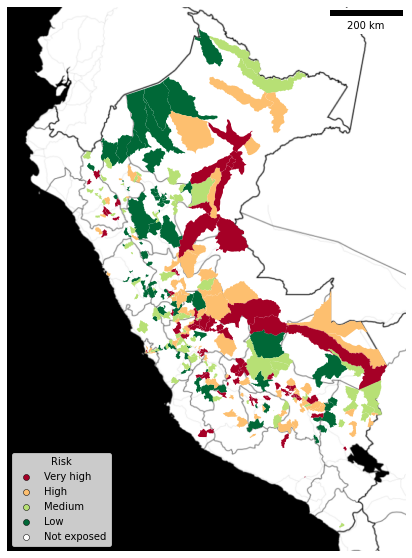

Shock: 1-500
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-500/peru_1-500_variables_table.csv


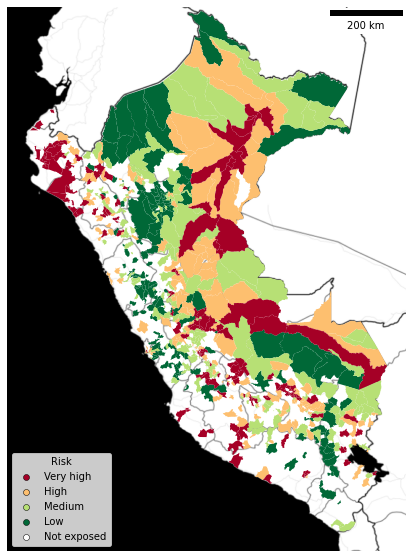

Shock: 1-1000
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-1000/peru_1-1000_variables_table.csv


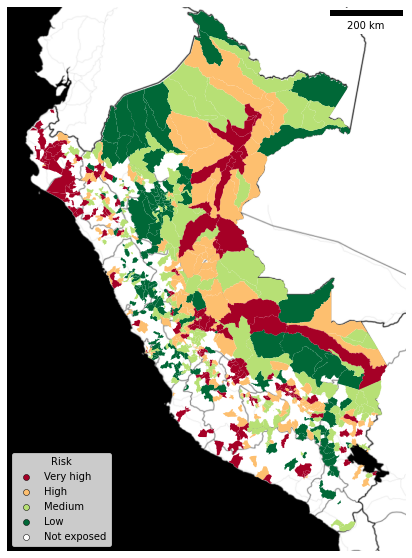

dict_keys(['1-5', '1-500', '1-1000'])

In [16]:
data_resumen_list = {}
for shock in shock_list:
    print("Shock:", shock)
    data_vector = None

    path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"
    print("Reading:", path)
    data_vector = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})

    df = data_vector.copy()
    better_values = ["ideal_values"] + ideal_values

    better_values = {
        col_name: pd.Series(val) for col_name, val in zip(df.columns, better_values)
    }
    better_values = pd.DataFrame(better_values)

    data_resumen = pd.concat([better_values, df], ignore_index=True)

    for elem in delete_columns_for[shock]:
        del data_resumen[elem]

    data_resumen = cosine_similarity_df(data_resumen)
    data_resumen = data_resumen.iloc[1:, :]
    data_resumen["Risk To Measure"] = data_resumen["Risk To Measure"].astype(float)

    # CUARTILES
    data_resumen["Risk Tag"] = pd.qcut(data_resumen["Risk To Measure"], 4, labels=False)
    data_resumen["Risk Tag"] = data_resumen["Risk Tag"] + 1

    data_resumen = pd.merge(
        fsupport.rename_columns(administrative_areas_dict[ADMINISTRATION_STUDY[:16]]),
        # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
        data_resumen,
        how="right",
        left_on=[
            ADMINISTRATION_STUDY,
        ],
        right_on=[
            ADMINISTRATION_STUDY,
        ],
        sort=True,
        suffixes=("_x", "_y"),
    )  # .sort_values(['CodigoPrestador'], ascending=False)

    data_resumen["Risk Tag"] = data_resumen["Risk Tag"].astype(int)

    # FIGURES --------------------------------

    data_temp = gpd.GeoDataFrame(data_resumen, geometry="geometry")
    col = "Risk Tag"
    data_temp = data_temp.sort_values(by=[col], ascending=[True])

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim([-82.0, -68.0])  # type: ignore # Límites en la coordenada X
    ax.set_ylim([-19.0, 0.1])  # type: ignore # Límites en la coordenada Y
    ax.axis("off")
    cmap_color = "RdYlGn_r"
    # cmap_color = 'RdYlGn'

    norm = fsupport.get_color_scale(data_temp, col)

    plot = data_temp.plot(
        ax=ax,
        column=col,
        cmap=cmap_color,
    )  # legend = True)
    ctx.add_basemap(
        plot,
        crs="epsg:4326",
        source=ctx.providers.Stamen.TonerBackground,
        attribution="",
    )

    A = [
        -70.1 * np.pi / 180.0,
        -2.5 * np.pi / 180.0,
    ]  # set latitude & longitude of interest here
    B = [
        -70.8 * np.pi / 180.0,
        -2.5 * np.pi / 180.0,
    ]  # set latitude & longitude (longitude in A +1) of interest here
    dx = (6371000) * haversine_distances([A, B])[0, 1]
    ax.add_artist(ScaleBar(dx=dx, units="m"))

    # Obtener los valores únicos de vulnerabilidad
    vulnerability_values = data_temp[col].unique()

    # Colores para la leyenda
    cmap = mpl.colormaps.get_cmap("RdYlGn_r")
    points = np.linspace(0, 1, len(vulnerability_values))
    legend_colors = mcolors.ListedColormap(cmap(points))

    # Añadir los puntos y las etiquetas en la leyenda
    labels_dict = {4: "Very high", 3: "High", 2: "Medium", 1: "Low"}

    if not fsupport.qty_departments_complete(
        COUNTRY_NAME, len(data_temp), administrative_level=3
    ):
        ax.scatter(
            [],
            [],
            color="white",
            label="Not exposed",
            edgecolors="black",
            linewidths=0.5,
        )

    for i, value in enumerate(vulnerability_values):
        ax.scatter(
            [],
            [],
            color=legend_colors(i),
            label=labels_dict[value],
            edgecolors="black",
            linewidths=0.5,
        )
        # ax.scatter([], [], color=legend_colors(i), label=value, edgecolors='black', linewidths=0.5)

    # Mostrar la leyenda
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]

    # Mostrar la leyenda invertida
    ax.legend(handles, labels, title="Risk", loc="lower left")
    # ax.legend(title='Risk', loc='lower right')

    path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_quartils_over_distance_figure.png"
    plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

    plt.show()

    data_resumen_to_save = data_resumen.copy()
    del data_resumen_to_save["geometry"]
    path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_quartils_over_distance_labeled_table.csv"
    data_resumen_to_save = data_resumen_to_save.sort_values(
        by=["Risk To Measure"], ascending=True
    )
    data_resumen_to_save.to_csv(path, index=False)

    data_resumen_list[shock] = data_temp

data_resumen_list.keys()

### Regiones


In [17]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import matplotlib.cm as cm

# if not os.path.exists(f"{directory}/department/"):
#     os.makedirs(f"{directory}/department/")

In [18]:
# DEPARTAMENTO = "LA LIBERTAD"

In [19]:
# # data_resumen_list = {}

# # DEPARTAMENTO = 'TACNA'
# dept_point = administrative_areas_dict["Administration 1"][
#     administrative_areas_dict["Administration 1"]["administration_1"] == DEPARTAMENTO
# ]["geometry"]
# bounds = dept_point.bounds

# for shock in shock_list:
#     print("Shock:", shock)
#     data_vector = None

#     path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"
#     print("Reading:", path)
#     data_vector = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})
#     initial_columns = data_vector.columns
#     data_vector = pd.merge(
#         fsupport.rename_columns(administrative_areas_dict[ADMINISTRATION_STUDY[:16]]),
#         # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
#         data_vector,
#         how="right",
#         left_on=[
#             ADMINISTRATION_STUDY,
#         ],
#         right_on=[
#             ADMINISTRATION_STUDY,
#         ],
#         sort=True,
#         suffixes=("_x", "_y"),
#     )

#     data_vector = data_vector[data_vector["Administration 1"] == DEPARTAMENTO]

#     data_resumen = data_vector[initial_columns].copy()
#     better_values = ["ideal_values"] + ideal_values

#     better_values = {
#         col_name: pd.Series(val)
#         for col_name, val in zip(data_resumen.columns, better_values)
#     }
#     better_values = pd.DataFrame(better_values)

#     data_resumen = pd.concat([better_values, data_resumen], ignore_index=True)

#     for elem in delete_columns_for[shock]:
#         del data_resumen[elem]

#     data_resumen = cosine_similarity_df(data_resumen)
#     data_resumen = data_resumen.iloc[1:, :]
#     data_resumen["Risk To Measure"] = data_resumen["Risk To Measure"].astype(float)

#     if len(data_resumen) > 0:
#         # CUARTILES
#         data_resumen["Risk Tag"] = pd.qcut(
#             data_resumen["Risk To Measure"], 4, labels=False
#         )
#         data_resumen["Risk Tag"] = data_resumen["Risk Tag"] + 1

#         data_resumen = pd.merge(
#             fsupport.rename_columns(
#                 administrative_areas_dict[ADMINISTRATION_STUDY[:16]]
#             ),
#             # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
#             data_resumen,
#             how="right",
#             left_on=[
#                 ADMINISTRATION_STUDY,
#             ],
#             right_on=[
#                 ADMINISTRATION_STUDY,
#             ],
#             sort=True,
#             suffixes=("_x", "_y"),
#         )

#         data_vector["Risk Tag"] = data_resumen["Risk Tag"].astype(int)

#         # FIGURES --------------------------------

#         data_temp = gpd.GeoDataFrame(data_resumen, geometry="geometry")
#         col = "Risk Tag"
#         data_temp = data_temp.sort_values(by=[col], ascending=[True])

#         fig, ax = plt.subplots(figsize=(14, 10))
#         ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
#         ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
#         ax.axis("off")

#         cmap_color = "RdYlGn_r"
#         # cmap_color = 'RdYlGn'

#         norm = fsupport.get_color_scale(data_temp, col)

#         plot = data_temp.plot(
#             ax=ax,
#             column=col,
#             cmap=cmap_color,
#         )  # legend = True)
#         ctx.add_basemap(
#             plot,
#             crs="epsg:4326",
#             source=ctx.providers.Stamen.TonerBackground,
#             attribution="",
#         )

#         A = [
#             -70.1 * np.pi / 180.0,
#             -2.5 * np.pi / 180.0,
#         ]  # set latitude & longitude of interest here
#         B = [
#             -70.8 * np.pi / 180.0,
#             -2.5 * np.pi / 180.0,
#         ]  # set latitude & longitude (longitude in A +1) of interest here
#         dx = (6371000) * haversine_distances([A, B])[0, 1]
#         ax.add_artist(ScaleBar(dx=dx, units="m"))

#         # Obtener los valores únicos de vulnerabilidad
#         vulnerability_values = data_temp[col].unique()

#         # Colores para la leyenda
#         cmap = mpl.colormaps.get_cmap("RdYlGn_r")
#         points = np.linspace(0, 1, len(vulnerability_values))
#         legend_colors = mcolors.ListedColormap(cmap(points))

#         # Añadir los puntos y las etiquetas en la leyenda
#         labels_dict = {4: "Very high", 3: "High", 2: "Medium", 1: "Low"}

#         if not fsupport.qty_departments_complete(
#             COUNTRY_NAME, len(data_temp), administrative_level=3
#         ):
#             ax.scatter(
#                 [],
#                 [],
#                 color="white",
#                 label="Not exposed",
#                 edgecolors="black",
#                 linewidths=0.5,
#             )

#         for i, value in enumerate(vulnerability_values):
#             ax.scatter(
#                 [],
#                 [],
#                 color=legend_colors(i),
#                 label=labels_dict[value],
#                 edgecolors="black",
#                 linewidths=0.5,
#             )
#             # ax.scatter([], [], color=legend_colors(i), label=value, edgecolors='black', linewidths=0.5)

#         # Mostrar la leyenda
#         handles, labels = ax.get_legend_handles_labels()
#         handles = handles[::-1]
#         labels = labels[::-1]

#         # Mostrar la leyenda invertida
#         ax.legend(handles, labels, title="Risk", loc="lower left")
#         # ax.legend(title='Risk', loc='lower right')

#         path = f"{directory}/department/{COUNTRY_NAME}_{DEPARTAMENTO}_{shock}_risk_figure.png"
#         plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

#         plt.show()

#         data_resumen_to_save = data_resumen.copy()
#         del data_resumen_to_save["geometry"]
#         data_resumen_to_save = data_resumen_to_save.sort_values(
#             by=["Risk To Measure"], ascending=True
#         )

#         path = f"{directory}/department/{COUNTRY_NAME}_{DEPARTAMENTO}_{shock}_risk_table.csv"
#         data_resumen_to_save.to_csv(path, index=False)


# # data_resumen_list.keys()

In [20]:
# for shock in shock_list:
#     print(shock)
#     # path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_quartils_over_distance_labeled_table.csv"
#     # path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"

#     # DEPARTAMENTO = 'TACNA'
#     dept_point = administrative_areas_dict["Administration 1"][
#         administrative_areas_dict["Administration 1"]["administration_1"]
#         == DEPARTAMENTO
#     ]["geometry"]
#     bounds = dept_point.bounds

#     """
#     Plot map shock
#     """

#     # Reading shape
#     path_shock_file = shock_dict[shock]
#     shock_shape = fsupport.shock_shape(path=path_shock_file, shock_name=shock)
#     shock_shape = shock_shape.intersection(list(dept_point)[0])

#     # if len(shock_shape) > 0:

#     if ~(shock_shape.is_empty.values[0]):
#         fig, ax = plt.subplots(figsize=(14, 10))
#         ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
#         ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
#         ax.axis("off")

#         # plot = shock_shape.plot(ax=ax, marker=".", color="gray", markersize=1, alpha=0.2)
#         plot = shock_shape.plot(ax=ax, marker=".", color="green", markersize=1)

#         ctx.add_basemap(
#             plot,
#             crs="epsg:4326",
#             source=ctx.providers.Stamen.TonerBackground,
#             attribution="",
#         )

#         # set latitude & longitude of interest here
#         A = [-70.1 * np.pi / 180.0, -2.5 * np.pi / 180.0]
#         # set latitude & longitude (longitude in A +1) of interest here
#         B = [-70.8 * np.pi / 180.0, -2.5 * np.pi / 180.0]
#         dx = (6371000) * haversine_distances([A, B])[0, 1]
#         ax.add_artist(ScaleBar(dx=dx, units="m"))

#         # Legend
#         red_dots = Line2D(
#             [0],
#             [0],
#             marker="o",
#             color="green",
#             markerfacecolor="green",
#             label=f"Exposed {shock} areas",
#             markersize=5,
#             linewidth=0,
#         )
#         ax.legend(
#             title="", handles=[red_dots], bbox_to_anchor=(0.05, 0.02), loc="lower left"
#         )

#         path = f"{directory}/department/{COUNTRY_NAME}_{DEPARTAMENTO}_{shock}_exposed_area.png"
#         plt.savefig(path, format="png", dpi=150, bbox_inches="tight")
#         print(path)

#         plt.show()
#         plt.close(fig)

In [21]:
# for shock in shock_list:
#     print(shock)
#     # path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_quartils_over_distance_labeled_table.csv"
#     # path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"

#     # DEPARTAMENTO = 'TACNA'
#     dept_point = administrative_areas_dict["Administration 1"][
#         administrative_areas_dict["Administration 1"]["administration_1"]
#         == DEPARTAMENTO
#     ]["geometry"]
#     bounds = dept_point.bounds

#     # POPULATION EXPOSED FOR
#     path = (
#         f"{directory}/{shock}/{COUNTRY_NAME}_exposed_population_{shock}_adm3_table.csv"
#     )
#     data_temp = pd.read_csv(path, dtype={"Administration 3 Code": str})

#     data_temp = data_temp[data_temp["Administration 1"] == DEPARTAMENTO]
#     data_temp = pd.merge(
#         data_temp,
#         administrative_areas_dict["Administration 3"][
#             ["administration_3_code", "geometry"]
#         ],
#         how="left",
#         left_on=["Administration 3 Code"],
#         right_on=["administration_3_code"],
#     )

#     data_temp = gpd.GeoDataFrame(data_temp, geometry="geometry")

#     """
#     Plot map intensity
#     """
#     transform_column = 0
#     cmap_color = "Blues"
#     leg_color = "Blue"
#     column_name = "Percentage"
#     trasformed_column = "temporal_column"

#     if transform_column < 0:
#         data_temp[trasformed_column] = data_temp[column_name].apply(
#             lambda x: pow(x, 1 / -1 * transform_column)
#         )
#     elif transform_column > 0:
#         data_temp[trasformed_column] = data_temp[column_name].apply(
#             lambda x: pow(x, transform_column)
#         )
#     else:
#         data_temp[trasformed_column] = data_temp[column_name]

#     fig, ax = plt.subplots(figsize=(14, 10))
#     ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
#     ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
#     ax.axis("off")

#     norm = fsupport.get_color_scale(data_temp, trasformed_column)

#     plot = data_temp.plot(ax=ax, column=trasformed_column, cmap=cmap_color)
#     ctx.add_basemap(
#         plot,
#         crs="epsg:4326",
#         source=ctx.providers.Stamen.TonerBackground,
#         attribution="",
#     )

#     # set latitude & longitude of interest here
#     A = [-70.1 * np.pi / 180.0, -2.5 * np.pi / 180.0]
#     # set latitude & longitude (longitude in A +1) of interest here
#     B = [-70.8 * np.pi / 180.0, -2.5 * np.pi / 180.0]
#     dx = (6371000) * haversine_distances([A, B])[0, 1]
#     ax.add_artist(ScaleBar(dx=dx, units="m"))

#     ticks = np.linspace(
#         data_temp[trasformed_column].min(),
#         data_temp[trasformed_column].max(),
#         num=5,
#         dtype=float,
#     )

#     labels = np.linspace(
#         data_temp[column_name].min(), data_temp[column_name].max(), num=5, dtype=int
#     )
#     labels = [f"{x}%" for x in labels]

#     cax = fig.add_axes(
#         [
#             ax.get_position().x1 + 0.05,
#             ax.get_position().y0,
#             0.01,
#             ax.get_position().height,
#         ]
#     )
#     cbar = fig.colorbar(
#         cm.ScalarMappable(norm=norm, cmap=cmap_color),
#         cax=cax,
#         orientation="vertical",
#         label="",
#         ticks=ticks,
#     )

#     cbar.ax.set_yticklabels(labels)

#     # Legend
#     red_dots = Line2D(
#         [0],
#         [0],
#         marker="o",
#         color=leg_color,
#         markerfacecolor=leg_color,
#         label="Percent of exposed population",
#         markersize=5,
#         linewidth=0,
#     )
#     ax.legend(
#         title="", handles=[red_dots], bbox_to_anchor=(0.05, 0.02), loc="lower left"
#     )

#     path = f"{directory}/department/{COUNTRY_NAME}_{DEPARTAMENTO}_{shock}_exposed_population.png"
#     plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

#     # plt.show()
#     plt.close(fig)

#     # INFRA EXPOSED FOR
#     path = f"{directory}/{shock}/{COUNTRY_NAME}_exposed_health_infrastructure_{shock}_adm3_table.csv"
#     # path = f"{directory}/{shock}/{COUNTRY_NAME}_exposed_health_infrastructure_{shock}_adm2_table.csv"
#     data_temp = pd.read_csv(
#         path,
#         dtype={
#             "Administration 1 Code": str,
#             "Administration 2 Code": str,
#             "Administration 3 Code": str,
#         },
#     )

#     data_temp = data_temp[data_temp["Administration 1"] == DEPARTAMENTO]
#     data_temp = pd.merge(
#         data_temp,
#         administrative_areas_dict["Administration 3"][
#             ["administration_3_code", "geometry"]
#         ],
#         # administrative_areas_dict['Administration 2'][['administration_2_code', 'geometry']],
#         how="left",
#         left_on=["Administration 3 Code"],
#         right_on=["administration_3_code"],
#     )

#     data_temp = gpd.GeoDataFrame(data_temp, geometry="geometry")

#     """
#     Plot map intensity

#     """
#     for CATEGORY in ["I", "II", "III"]:
#         print(f"       ...for category: {CATEGORY}")

#         transform_column = 0
#         cmap_color = "Reds"
#         leg_color = "Red"
#         column_name = "Percentage Category " + CATEGORY
#         trasformed_column = "temporal_column"

#         if transform_column < 0:
#             data_temp[trasformed_column] = data_temp[column_name].apply(
#                 lambda x: pow(x, 1 / -1 * transform_column)
#             )
#         elif transform_column > 0:
#             data_temp[trasformed_column] = data_temp[column_name].apply(
#                 lambda x: pow(x, transform_column)
#             )
#         else:
#             data_temp[trasformed_column] = data_temp[column_name]

#         norm = fsupport.get_color_scale(data_temp, trasformed_column)

#         fig, ax = plt.subplots(figsize=(14, 10))
#         ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
#         ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
#         ax.axis("off")

#         plot = data_temp.plot(
#             ax=ax,
#             column=trasformed_column,
#             cmap=cmap_color,
#         )
#         ctx.add_basemap(
#             plot,
#             crs="epsg:4326",
#             source=ctx.providers.Stamen.TonerBackground,
#             attribution="",
#         )

#         # set latitude & longitude of interest here
#         A = [-70.1 * np.pi / 180.0, -2.5 * np.pi / 180.0]
#         B = [-70.8 * np.pi / 180.0, -2.5 * np.pi / 180.0]
#         dx = (6371000) * haversine_distances([A, B])[0, 1]
#         ax.add_artist(ScaleBar(dx=dx, units="m"))

#         ticks = np.linspace(
#             data_temp[trasformed_column].min(),
#             data_temp[trasformed_column].max(),
#             num=5,
#             dtype=float,
#         )

#         labels = np.linspace(
#             data_temp[column_name].min(), data_temp[column_name].max(), num=5, dtype=int
#         )
#         labels = [f"{x}%" for x in labels]

#         cax = fig.add_axes(
#             [
#                 ax.get_position().x1 + 0.05,
#                 ax.get_position().y0,
#                 0.01,
#                 ax.get_position().height,
#             ]
#         )
#         cbar = fig.colorbar(
#             cm.ScalarMappable(norm=norm, cmap=cmap_color),
#             cax=cax,
#             orientation="vertical",
#             label="",
#             ticks=ticks,
#         )

#         cbar.ax.set_yticklabels(labels)
#         # Legend
#         red_dots = Line2D(
#             [0],
#             [0],
#             marker="o",
#             color=leg_color,
#             markerfacecolor=leg_color,
#             label=f"Percent of exposed healthcare infrastructure (category {CATEGORY})",
#             markersize=5,
#             linewidth=0,
#         )
#         ax.legend(
#             title="", handles=[red_dots], bbox_to_anchor=(0.05, 0.02), loc="lower left"
#         )

#         path = f"{directory}/department/{COUNTRY_NAME}_{DEPARTAMENTO}_{shock}_cat-{CATEGORY}_infra_population.png"
#         plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

#         # plt.show()
#         plt.close(fig)

In [22]:
data_temp[
    [
        "Administration 1",
        "Administration 2",
        "Administration 3",
        "Percentage Category I",
        "Percentage Category II",
        "Percentage Category III",
        "geometry",
    ]
]

,Administration 1,Administration 2,Administration 3,Percentage Category I,Percentage Category II,Percentage Category III,geometry
752,UCAYALI,PURUS,PURUS,0.2500,0.0,0.0,"POLYGON ((-70.61380 -9.87339, -70.62140 -9.878..."
628,PUNO,CARABAYA,CORANI,0.6000,0.0,0.0,"POLYGON ((-70.51798 -13.89704, -70.51777 -13.8..."
714,SAN MARTIN,SAN MARTIN,ALBERTO LEVEAU,1.0000,0.0,0.0,"POLYGON ((-76.23401 -6.65341, -76.23471 -6.658..."
630,PUNO,CARABAYA,ITUATA,0.3333,0.0,0.0,"POLYGON ((-70.20911 -14.05767, -70.21133 -14.0..."
438,LA LIBERTAD,SANCHEZ CARRION,SANAGORAN,0.0000,0.0,0.0,"POLYGON ((-78.11683 -7.65376, -78.11605 -7.654..."
...,...,...,...,...,...,...,...
354,JUNIN,HUANCAYO,HUAYUCACHI,0.0000,0.0,0.0,"POLYGON ((-75.19735 -12.12583, -75.19852 -12.1..."
353,JUNIN,HUANCAYO,HUANCAN,0.0000,0.0,0.0,"POLYGON ((-75.18594 -12.10812, -75.18254 -12.1..."
352,JUNIN,HUANCAYO,HUALHUAS,0.0000,0.0,0.0,"POLYGON ((-75.21033 -11.94566, -75.21074 -11.9..."
364,JUNIN,HUANCAYO,VIQUES,0.0000,0.0,0.0,"POLYGON ((-75.20884 -12.15655, -75.21034 -12.1..."


<Axes: >

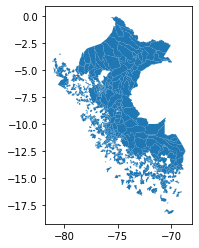

In [23]:
data_temp.plot()

## KMEANS


Shock: 1-5
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-5/peru_1-5_variables_table.csv
[[0.30342852144741794], [0.6475240149992463], [0.7951011392722923], [0.8687564463631882]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


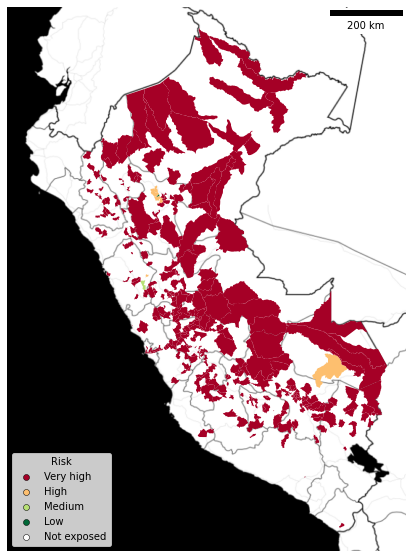

Shock: 1-500
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-500/peru_1-500_variables_table.csv
[[0.303499898789652], [0.6739375954166398], [0.8303082422012864], [0.8687111158660777]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


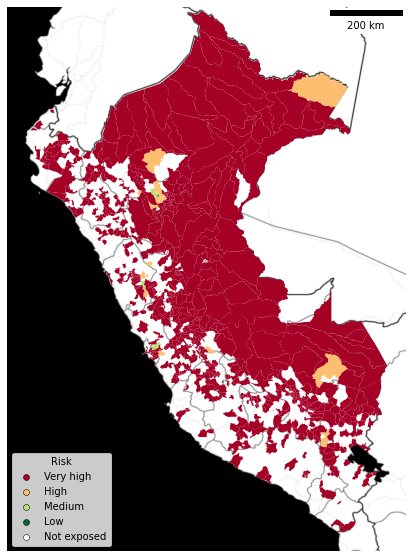

Shock: 1-1000
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-1000/peru_1-1000_variables_table.csv
[[0.3035282729661811], [0.6739374927636306], [0.8309061854594746], [0.8687155056389648]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


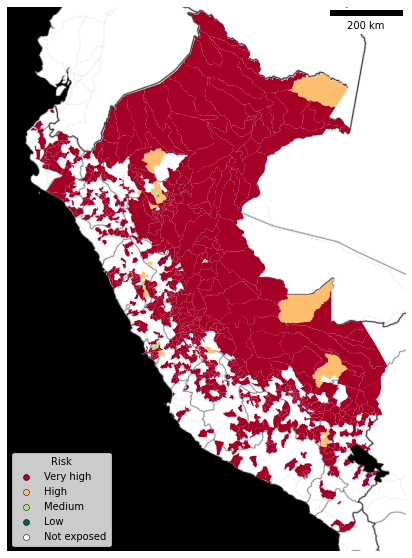

Shock: 1-5
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-5/peru_1-5_variables_table.csv
[[0.30342852144741794], [0.6475240149992463], [0.7643207169243856], [0.8315681175999368], [0.8691863651864005]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


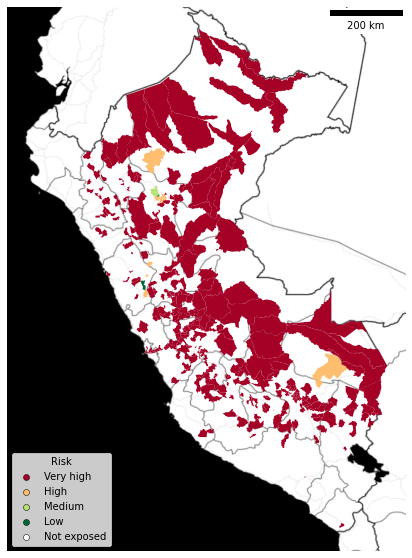

Shock: 1-500
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-500/peru_1-500_variables_table.csv
[[0.303499898789652], [0.6400680296993138], [0.7809711987739987], [0.8401408445142405], [0.8688079543052274]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


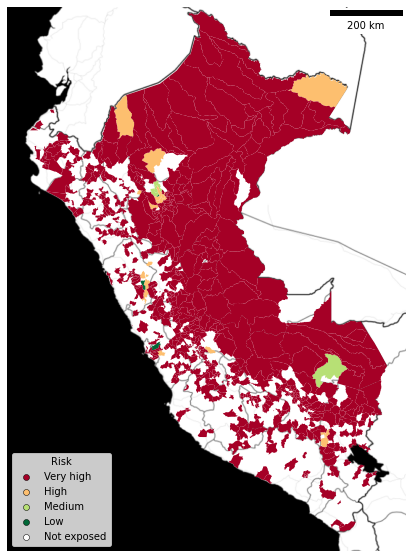

Shock: 1-1000
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-1000/peru_1-1000_variables_table.csv
[[0.3035282729661811], [0.6400680296993138], [0.7809711371821931], [0.840739934834346], [0.8688581350579939]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


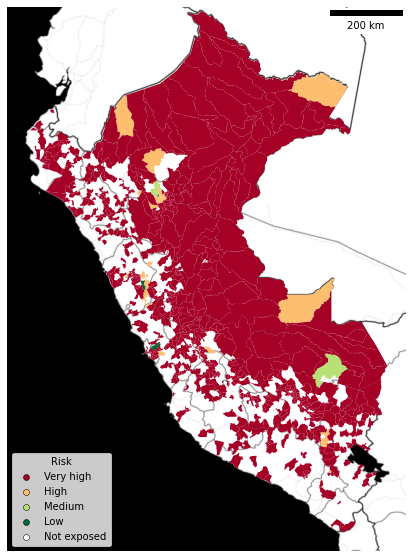

Shock: 1-5
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-5/peru_1-5_variables_table.csv
[[0.30342852144741794], [0.6475240149992463], [0.7643207169243856], [0.8268869085108426], [0.8613621138277654], [0.8698126453512676]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


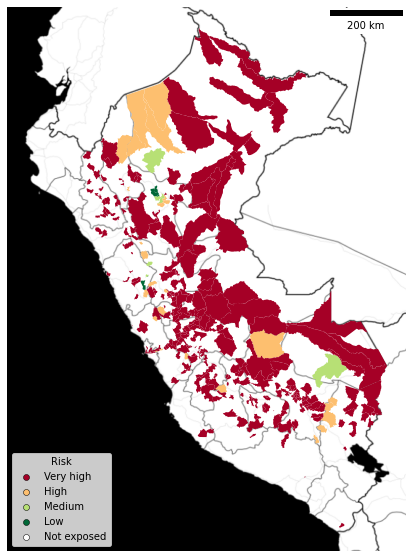

Shock: 1-500
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-500/peru_1-500_variables_table.csv
[[0.303499898789652], [0.6400680296993138], [0.7643200772452293], [0.8315499977455875], [0.8596445685750386], [0.8695988928779929]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


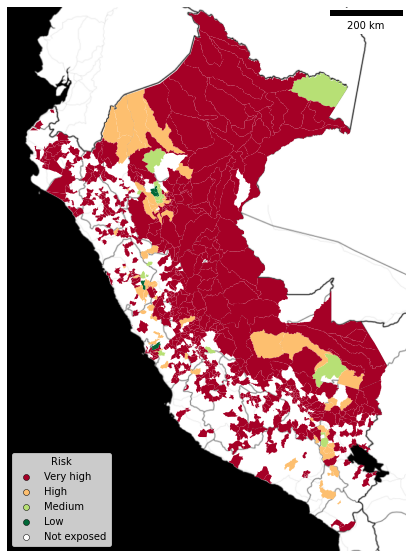

Shock: 1-1000
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_RETURN_FLOODS/1-1000/peru_1-1000_variables_table.csv
[[0.3035282729661811], [0.6400680296993138], [0.7643199745922201], [0.8322330503468043], [0.8594566911569851], [0.8696350369262474]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


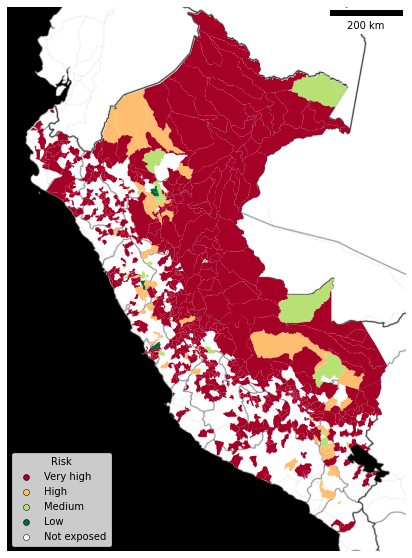

,Administration 1 Code,Administration 2 Code,Administration 3 Code,Administration 1,Administration 2,Administration 3,Percentage,Percentage Category I,Percentage Category II,Percentage Category III,...,ValorEESSconmayorcapacidadr,MEDICOX10000HABITANTENORMAL,Per Ess 100hab,PHC Dist Km,Hospital Dist Km,Rr Eda,Cosine Similarity,Cosine Distance,Risk To Measure,Risk Tag
0,01,0101,010101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,0.0013,0.00,0.0,0.0,...,0.09,3.962652,4.995941,6667.752627,6671.790868,1.491073,0.1291737848355706,0.870826,0.870826,4
1,01,0101,010103,AMAZONAS,CHACHAPOYAS,BALSAS,0.3990,0.50,0.0,0.0,...,0.18,8.382230,84.745766,7485.610227,7488.471564,1.491073,0.13372936905602062,0.866271,0.866271,4
2,01,0101,010109,AMAZONAS,CHACHAPOYAS,LA JALCA,0.0221,0.00,0.0,0.0,...,0.18,5.144033,37.656902,6305.485005,6309.191998,1.491073,0.13141737584269955,0.868583,0.868583,4
3,01,0101,010113,AMAZONAS,CHACHAPOYAS,MARISCAL CASTILLA,0.7861,0.25,0.0,0.0,...,0.35,0.000000,20.491804,6062.248777,6066.084965,1.491073,0.12991948123226146,0.870081,0.870081,4
4,01,0101,010118,AMAZONAS,CHACHAPOYAS,SAN FRANCISCO DE DAGUAS,0.3197,0.00,0.0,0.0,...,0.35,29.850746,44.247787,5687.831716,5691.859686,1.491073,0.13467829453188462,0.865322,0.865322,4


In [24]:
for K_NUM in [4, 5, 6]:
    for shock in shock_list:
        print("Shock:", shock)
        data_vector = None

        path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"
        print("Reading:", path)
        data_vector = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})

        df = data_vector.copy()
        better_values = ["ideal_values"] + ideal_values

        better_values = {
            col_name: pd.Series(val) for col_name, val in zip(df.columns, better_values)
        }
        better_values = pd.DataFrame(better_values)

        data_resumen = pd.concat([better_values, df], ignore_index=True)
        data_resumen = cosine_similarity_df(data_resumen)
        data_resumen = data_resumen.iloc[1:, :]

        for elem in delete_columns_for[shock]:
            del data_resumen[elem]

        data_resumen["Risk To Measure"] = data_resumen["Risk To Measure"].astype(float)
        X = data_resumen[["Risk To Measure"]]
        kmeans = KMeans(n_clusters=K_NUM, random_state=42).fit(X)

        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_.tolist()

        centroids_order = sorted(centroids, key=lambda x: x)
        index_orders = [centroids.index(x) for x in centroids_order]
        labels_order = [index_orders.index(i) + 1 for i in labels]

        print(centroids_order)

        data_resumen["Risk Tag"] = labels_order

        data_resumen = pd.merge(
            fsupport.rename_columns(
                administrative_areas_dict[ADMINISTRATION_STUDY[:16]]
            ),
            # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
            data_resumen,
            how="right",
            left_on=[
                ADMINISTRATION_STUDY,
            ],
            right_on=[
                ADMINISTRATION_STUDY,
            ],
            sort=True,
            suffixes=("_x", "_y"),
        )  # .sort_values(['CodigoPrestador'], ascending=False)

        data_resumen["Risk Tag"] = data_resumen["Risk Tag"].astype(int)

        if K_NUM == 6:
            dict_re_order = {1: 1, 2: 1, 3: 1, 4: 2, 5: 3, 6: 4}  # k=6
            data_resumen["Risk Tag"] = (
                data_resumen["Risk Tag"].replace(dict_re_order).astype(int)
            )

        if K_NUM == 5:
            dict_re_order = {1: 1, 2: 1, 3: 2, 4: 3, 5: 4}  # k=5
            data_resumen["Risk Tag"] = (
                data_resumen["Risk Tag"].replace(dict_re_order).astype(int)
            )

        # FIGURES --------------------------------

        data_temp = gpd.GeoDataFrame(data_resumen, geometry="geometry")
        col = "Risk Tag"
        data_temp = data_temp.sort_values(by=[col], ascending=[True])

        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim([-82.0, -68.0])  # type: ignore # Límites en la coordenada X
        ax.set_ylim([-19.0, 0.1])  # type: ignore # Límites en la coordenada Y
        ax.axis("off")
        cmap_color = "RdYlGn_r"
        # cmap_color = 'RdYlGn'

        norm = fsupport.get_color_scale(data_temp, col)

        plot = data_temp.plot(
            ax=ax,
            column=col,
            cmap=cmap_color,
        )  # legend = True)
        ctx.add_basemap(
            plot,
            crs="epsg:4326",
            source=ctx.providers.Stamen.TonerBackground,
            attribution="",
        )

        A = [
            -70.1 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude of interest here
        B = [
            -70.8 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude (longitude in A +1) of interest here
        dx = (6371000) * haversine_distances([A, B])[0, 1]
        ax.add_artist(ScaleBar(dx=dx, units="m"))

        # Obtener los valores únicos de vulnerabilidad
        vulnerability_values = data_temp[col].unique()

        # Colores para la leyenda
        cmap = mpl.colormaps.get_cmap("RdYlGn_r")
        points = np.linspace(0, 1, len(vulnerability_values))
        legend_colors = mcolors.ListedColormap(cmap(points))

        # Añadir los puntos y las etiquetas en la leyenda
        labels_dict = {4: "Very high", 3: "High", 2: "Medium", 1: "Low"}

        if not fsupport.qty_departments_complete(
            COUNTRY_NAME, len(data_temp), administrative_level=3
        ):
            ax.scatter(
                [],
                [],
                color="white",
                label="Not exposed",
                edgecolors="black",
                linewidths=0.5,
            )

        for i, value in enumerate(vulnerability_values):
            ax.scatter(
                [],
                [],
                color=legend_colors(i),
                label=labels_dict[value],
                edgecolors="black",
                linewidths=0.5,
            )
            # ax.scatter([], [], color=legend_colors(i), label=value, edgecolors='black', linewidths=0.5)

        # Mostrar la leyenda
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]

        # Mostrar la leyenda invertida
        ax.legend(handles, labels, title="Risk", loc="lower left")
        # ax.legend(title='Risk', loc='lower right')

        path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_kmeans{K_NUM}_over_distance_figure.png"
        plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

        plt.show()

        del data_resumen["geometry"]
        path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_kmeans{K_NUM}_over_distance_labeled_table.csv"
        data_resumen.to_csv(path, index=False)
data_resumen.head()

In [25]:
ADMINISTRATION_STUDY[:16]

'Administration 3'

# End


## generating risk list de top 3 bottom 3


In [26]:
shock_list = [
    "1-5",
    "1-500",
    "1-1000",
]

In [27]:
data_sample = pd.DataFrame()
for s in shock_list:
    path = f"{PATH_DATA}/data/peru/{RESULT_DIR}/{s}/peru_{s}_ranking_quartils_over_distance_labeled_table.csv"
    data_temp = pd.read_csv(path)
    data_temp = data_temp[
        [
            "Administration 1",
            "Administration 2",
            "Administration 3",
            "Risk To Measure",
            "Risk Tag",
        ]
    ]
    for i in set(data_temp["Risk Tag"]):
        data_temp_sub = data_temp[data_temp["Risk Tag"] == i]
        top_3 = data_temp_sub.head(3)
        dummy_row = pd.DataFrame(
            {
                "Administration 1": ["..."],
                "Administration 2": ["..."],
                "Administration 3": ["..."],
                "Risk To Measure": [None],
                "Risk Tag": [i],
            }
        )
        bottom_3 = data_temp_sub.tail(3)
        top_3 = pd.concat([top_3, dummy_row])
        top_3 = pd.concat([top_3, bottom_3])
        top_3["shock"] = s
        data_sample = pd.concat([data_sample, top_3])

data_sample = data_sample.reset_index(drop=True)
data_sample

,Administration 1,Administration 2,Administration 3,Risk To Measure,Risk Tag,shock
0,SAN MARTIN,EL DORADO,SHATOJA,0.294318,1,1-5
1,ANCASH,HUARI,CHAVIN DE HUANTAR,0.649972,1,1-5
2,SAN MARTIN,EL DORADO,SAN MARTIN,0.742805,1,1-5
3,...,...,...,NaN,1,1-5
4,HUANUCO,HUANUCO,MARGOS,0.868051,1,1-5
...,...,...,...,...,...,...
79,LIMA,HUAURA,HUAURA,0.870596,4,1-1000
80,...,...,...,NaN,4,1-1000
81,CUSCO,CUSCO,SAN SEBASTIAN,0.871226,4,1-1000
82,LA LIBERTAD,CHEPEN,PACANGA,0.871263,4,1-1000


In [28]:
data_sample = pd.DataFrame()
for s in shock_list:
    path = f"{PATH_DATA}/data/peru/{RESULT_DIR}/{s}/peru_{s}_ranking_kmeans4_over_distance_labeled_table.csv"
    data_temp = pd.read_csv(path)
    data_temp = data_temp[
        [
            "Administration 1",
            "Administration 2",
            "Administration 3",
            "Risk To Measure",
            "Risk Tag",
        ]
    ]
    for i in set(data_temp["Risk Tag"]):
        data_temp_sub = data_temp[data_temp["Risk Tag"] == i]
        top_3 = data_temp_sub.head(3)
        dummy_row = pd.DataFrame(
            {
                "Administration 1": ["..."],
                "Administration 2": ["..."],
                "Administration 3": ["..."],
                "Risk To Measure": [None],
                "Risk Tag": [i],
            }
        )
        bottom_3 = data_temp_sub.tail(3)
        top_3 = pd.concat([top_3, dummy_row])
        top_3 = pd.concat([top_3, bottom_3])
        top_3["shock"] = s
        data_sample = pd.concat([data_sample, top_3])

data_sample = data_sample.reset_index(drop=True)
data_sample

path = f"{PATH_DATA}/data/peru/{RESULT_DIR}/peru_abstract_ranking_kmeans4_over_distance_labeled_table.csv"
data_sample.to_csv(path, index=False)

data_sample

,Administration 1,Administration 2,Administration 3,Risk To Measure,Risk Tag,shock
0,SAN MARTIN,EL DORADO,SHATOJA,0.303429,1,1-5
1,...,...,...,NaN,1,1-5
2,SAN MARTIN,EL DORADO,SHATOJA,0.303429,1,1-5
3,ANCASH,HUARI,CHAVIN DE HUANTAR,0.647524,2,1-5
4,...,...,...,NaN,2,1-5
...,...,...,...,...,...,...
63,AMAZONAS,CHACHAPOYAS,LA JALCA,0.868583,4,1-1000
64,...,...,...,NaN,4,1-1000
65,UCAYALI,PADRE ABAD,IRAZOLA,0.870602,4,1-1000
66,UCAYALI,PADRE ABAD,CURIMANA,0.870648,4,1-1000
